In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Quantum Circuit Simulation with Fixed Rank BUG

In [140]:
from typing import List
from copy import deepcopy
from matplotlib.pyplot import subplots, show

from numpy import eye, ndarray, kron, pi, append, zeros
from matplotlib.pyplot import subplots, show

## Exact Reference Solution

In [141]:
from pytreenet.operators.common_operators import (ket_i,
                                                  superposition,
                                                  pauli_matrices)
from pytreenet.util.tensor_util import multi_kron
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution
from pytreenet.operators.exact_operators import exact_local_magnetisation

In [142]:
local_dim = 2
num_sites = 4
time_step_size = 0.001
final_time = pi / 4 # This is how long a CNOT gate takes to apply

In [143]:
# Initial State
ket_0 = ket_i(0, local_dim)
exact_init_state = multi_kron(superposition(), deepcopy(ket_0), deepcopy(ket_0), superposition())
print(exact_init_state.shape)

(16,)


In [161]:
def gen_cnot_ham_matrix(control: bool) -> ndarray:
    """
    Generate the matrix representation of a CNOT gate Hamiltonian.

    Args:
        control: Whether the left qubit is the control qubit (True) or the right qubit (False).

    Returns:
        ndarray: Matrix representation of the CNOT gate Hamiltonian.

    """
    dim = 2
    identity = eye(dim)
    sigma_x, _, sigma_z = pauli_matrices()
    if control:
        return kron(identity - sigma_z, identity - sigma_x)
    else:
        return kron(identity - sigma_x, identity - sigma_z)

In [180]:
cnonnotcham = kron(gen_cnot_ham_matrix(True), gen_cnot_ham_matrix(False))
import numpy as np
from scipy.linalg import expm
cnot = np.asarray([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0]])
notc = np.asarray([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])
cnotnotc = kron(cnot, notc)
found_cnotnotc = expm(-1j * pi / 4 * cnonnotcham)
print(np.max(np.abs(cnotnotc - found_cnotnotc)))
cnotnotc

1.0000000000000004


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [176]:
np.round(expm(-1j * pi / 4 * gen_cnot_ham_matrix(True)), decimals=3)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.-0.j]])

In [145]:
# Hamiltonians
identity = eye(local_dim)
exact_ham_1 = kron(gen_cnot_ham_matrix(True), gen_cnot_ham_matrix(False))
exact_ham_2 = kron(identity, kron(gen_cnot_ham_matrix(False), identity))
exact_ham_3 = kron(identity, kron(gen_cnot_ham_matrix(True), identity))
print(exact_ham_1.shape, exact_ham_2.shape, exact_ham_3.shape)

(16, 16) (16, 16) (16, 16)


In [146]:
# Operators
qubit_ids = [f"Qubit_{i}" for i in range(num_sites)]
exact_operators = exact_local_magnetisation(qubit_ids)
print([op.shape for op in exact_operators.values()])

[(16, 16), (16, 16), (16, 16), (16, 16)]


In [147]:
# Simulation
exact_1 = ExactTimeEvolution(exact_init_state, exact_ham_1, time_step_size, final_time, exact_operators)
exact_1.run()
exact_2 = ExactTimeEvolution(exact_1.state, exact_ham_2, time_step_size, final_time, exact_operators)
exact_2.run()
exact_3 = ExactTimeEvolution(exact_2.state, exact_ham_3, time_step_size, final_time, exact_operators)
exact_3.run()

100%|██████████| 787/787 [00:00<00:00, 25426.88it/s]


In [182]:
print(exact_1._time_evolution_operator**787)
print(exact_1.time_step_size*787)

[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j     

### Exact Solution: Plotting

In [148]:
def simulation_results(qubit_id: str, simulations: List) -> ndarray:
    """
    Gets the results of the exact simulations for a given qubit and concatenates them.
    """
    results = []
    for sim in reversed(simulations):
        res = sim.operator_result(qubit_id, realise=True)
        results = append(res, results)
    return results

In [149]:
exact_results = {qubit_id: simulation_results(qubit_id, [exact_1, exact_2, exact_3]) for qubit_id in qubit_ids}
for qubit_id, results in exact_results.items():
    print(qubit_id, results.shape)

times = append(exact_1.times(), append(exact_2.times(offset=pi/4), exact_3.times(offset=pi/2)))
print("Times", times.shape)

Qubit_0 (2361,)
Qubit_1 (2361,)
Qubit_2 (2361,)
Qubit_3 (2361,)
Times (2361,)


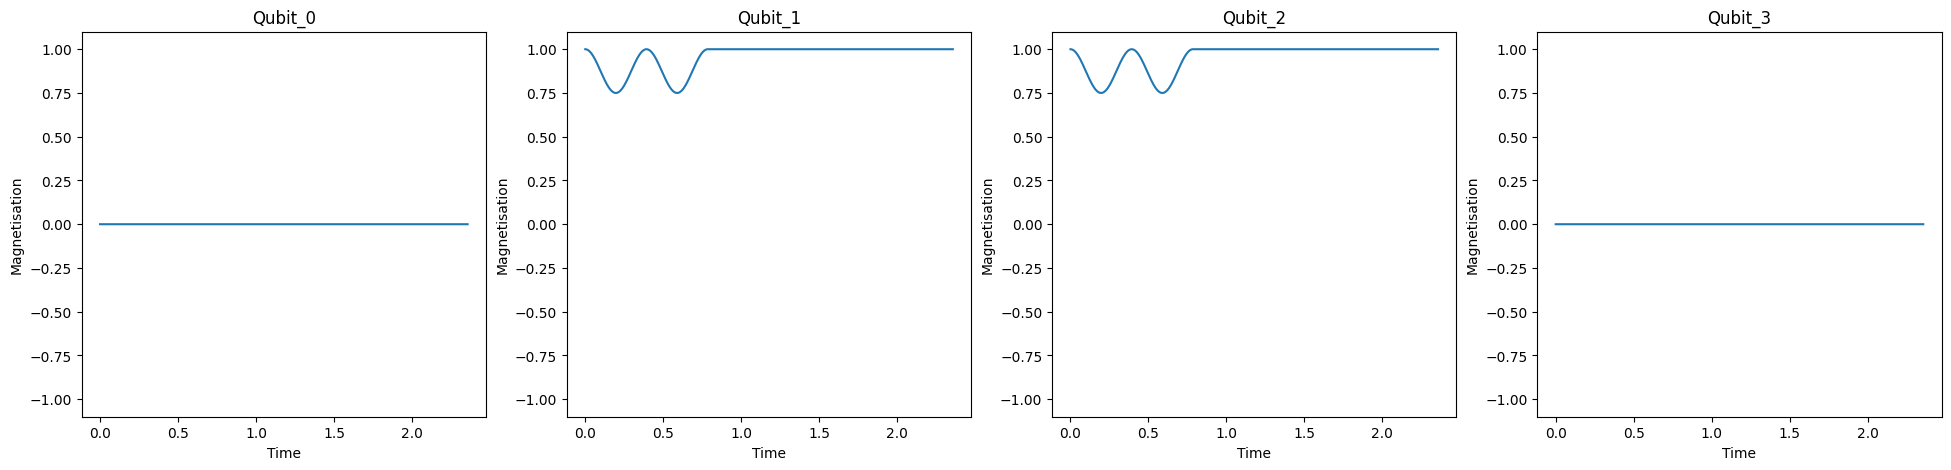

In [150]:
fig, axs = subplots(1, 4, figsize=(24, 5))
for i, qubit_id in enumerate(qubit_ids):
    axs[i].set_ylim(-1.1, 1.1)
    axs[i].plot(times, exact_results[qubit_id])
    axs[i].set_title(qubit_id)
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Magnetisation")
show()

## Binary Tree

In [151]:
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.core.node import Node
from pytreenet.operators.hamiltonian import Hamiltonian
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.time_evolution.fixed_bug import FixedBUG
from pytreenet.operators.models import local_magnetisation

In [152]:
root_tensor = zeros([local_dim**2, local_dim**2, 1],
                    dtype=complex)
root_tensor[0, 0, 0] = 1

mid_tensor = zeros([local_dim**2, local_dim, local_dim, 1],
                    dtype=complex)
mid_tensor[0, 0, 0, 0] = 1

qubit_tensors = [zeros([local_dim, local_dim],
                      dtype=complex) for _ in range(num_sites)]
qubit_states = [superposition(), deepcopy(ket_0), deepcopy(ket_0), superposition()]
for i, qubit_state in enumerate(qubit_states):
    qubit_tensors[i][0, :] = qubit_state

print("Root Tensor Shape:", root_tensor.shape)
print("Middle Tensor Shape:", mid_tensor.shape)
print("Qubit Tensor Shape:", qubit_tensors[0].shape)

binary_ttns = TreeTensorNetworkState()
root_id = "Root"
root_node = Node(identifier=root_id)
binary_ttns.add_root(root_node, root_tensor)
middle_ids = [f"Middle {i}" for i in range(2)]
for i, identifier in enumerate(middle_ids):
    middle_node = Node(identifier=identifier)
    binary_ttns.add_child_to_parent(middle_node,
                                    deepcopy(mid_tensor),
                                    0,
                                    root_id,
                                    i)

qubit_ids = [f"Qubit_{i}" for i in range(num_sites)]
parent_legs = [1,2,1,2]
parent_ids = [middle_ids[0], middle_ids[0], middle_ids[1], middle_ids[1]]
for i, identifier in enumerate(qubit_ids):
    qubit_node = Node(identifier=identifier)
    binary_ttns.add_child_to_parent(qubit_node,
                                    qubit_tensors[i],
                                    0,
                                    parent_ids[i],
                                    parent_legs[i])

Root Tensor Shape: (4, 4, 1)
Middle Tensor Shape: (4, 2, 2, 1)
Qubit Tensor Shape: (2, 2)


In [153]:
def gen_cnot_hamiltonian(control_id: str,
                         target_id: str
                         ) -> Hamiltonian:
    """
    Generate a CNOT Hamiltonian for a given control and target qubit.

    Args:
        control_id: Identifier of the control qubit.
        target_id: Identifier of the target qubit.

    Returns:
        Hamiltonian: Hamiltonian for the CNOT gate.
    """
    dim = 2
    identity = eye(dim)
    term = TensorProduct({control_id: "q0_op", target_id: "q1_op"})
    q0_op = identity - pauli_matrices()[2]
    q1_op = identity - pauli_matrices()[0]
    conv_dict = {"I1": eye(1), "I2": identity, "q0_op": q0_op, "q1_op": q1_op}
    hamiltonian = Hamiltonian(term, conversion_dictionary=conv_dict)
    return hamiltonian

In [154]:
# Hamiltonians
binary_ham_1 = gen_cnot_hamiltonian(qubit_ids[0], qubit_ids[1])
binary_ham_1.add_hamiltonian(gen_cnot_hamiltonian(qubit_ids[3], qubit_ids[2]))
binary_ttno_1 = TreeTensorNetworkOperator.from_hamiltonian(binary_ham_1, binary_ttns)
binary_ham_2 = gen_cnot_hamiltonian(qubit_ids[2], qubit_ids[1])
binary_ttno_2 = TreeTensorNetworkOperator.from_hamiltonian(binary_ham_2, binary_ttns)
binary_ham_3 = gen_cnot_hamiltonian(qubit_ids[1], qubit_ids[2])
binary_ttno_3 = TreeTensorNetworkOperator.from_hamiltonian(binary_ham_3, binary_ttns)

In [155]:
bug_operators = local_magnetisation(qubit_ids)
norm_id = "Norm"
bug_operators[norm_id] = TensorProduct({qubit_ids[0]: eye(local_dim)})

In [156]:
binary_bug1 = FixedBUG(binary_ttns, binary_ttno_1, time_step_size, final_time, bug_operators)
binary_bug1.run()
binary_bug2 = FixedBUG(binary_bug1.state, binary_ttno_2, time_step_size, final_time, bug_operators)
binary_bug2.run()
binary_bug3 = FixedBUG(binary_bug2.state, binary_ttno_3, time_step_size, final_time, bug_operators)
binary_bug3.run()

  1%|          | 9/787 [00:00<00:08, 88.66it/s]

100%|██████████| 787/787 [00:09<00:00, 81.02it/s]


### Binary Tree: Results

In [157]:
binary_norm = simulation_results(norm_id, [binary_bug1, binary_bug2, binary_bug3])
binary_norm_error = abs(binary_norm - 1)

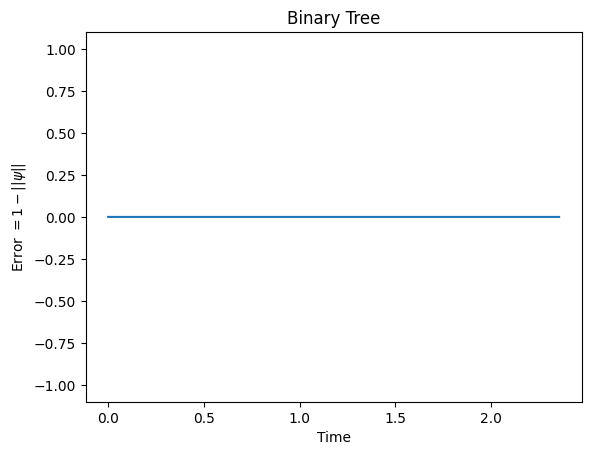

In [158]:
fig, ax = subplots(1, 1)
ax.set_ylim(-1.1, 1.1)
ax.plot(times, binary_norm_error)
ax.set_xlabel("Time")
ax.set_ylabel(r"Error $=1 - ||\psi||$")
ax.set_title("Binary Tree")

show()

In [159]:
binary_results = {qubit_id: simulation_results(qubit_id, [binary_bug1, binary_bug2, binary_bug3]) for qubit_id in qubit_ids}
for qubit_id, results in binary_results.items():
    print(qubit_id, results.shape)
binary_error = {qubit_id: abs(exact_results[qubit_id] - binary_results[qubit_id]) for qubit_id in qubit_ids}

Qubit_0 (2361,)
Qubit_1 (2361,)
Qubit_2 (2361,)
Qubit_3 (2361,)


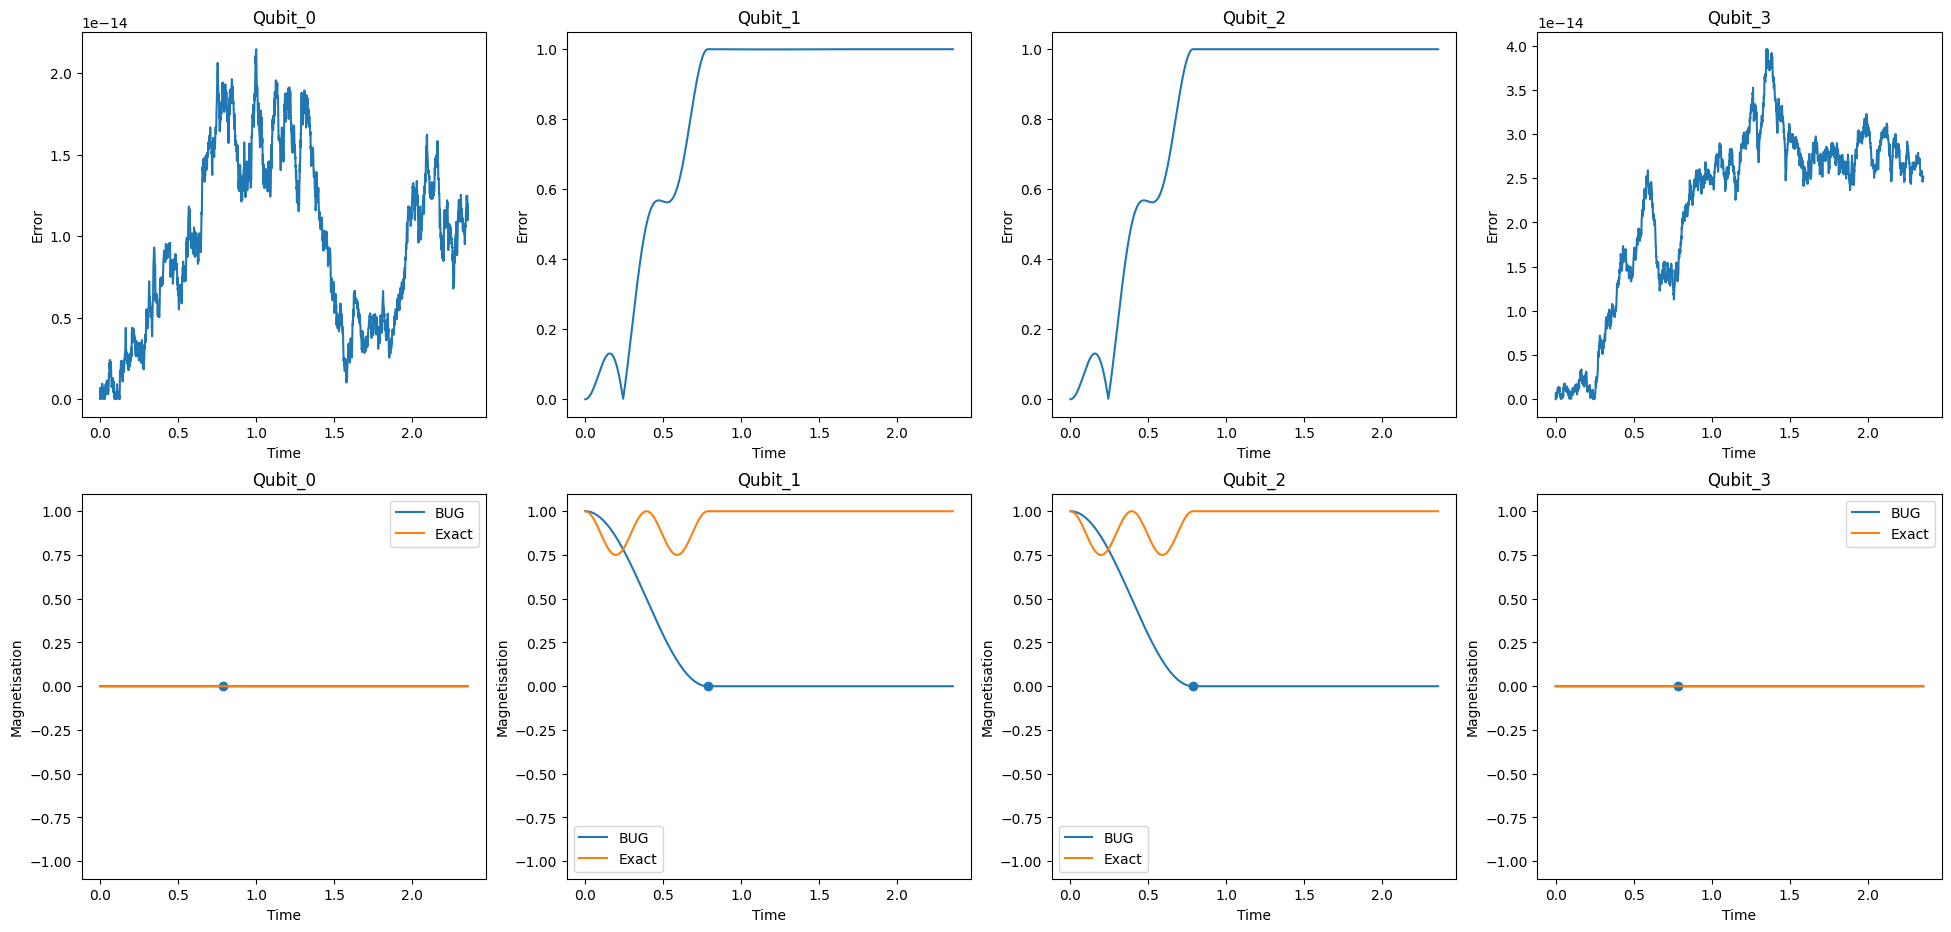

In [163]:
fig, axs = subplots(2, 4, figsize=(24, 11))
for i, qubit_id in enumerate(qubit_ids):
    axs[0][i].plot(times, binary_error[qubit_id])
    axs[0][i].set_title(qubit_id)
    axs[0][i].set_xlabel("Time")
    axs[0][i].set_ylabel("Error")
    axs[1][i].plot(times, binary_results[qubit_id], label="BUG")
    axs[1][i].plot(times, exact_results[qubit_id], label="Exact")
    axs[1][i].set_title(qubit_id)
    axs[1][i].set_xlabel("Time")
    axs[1][i].set_ylabel("Magnetisation")
    axs[1][i].set_ylim(-1.1, 1.1)
    axs[1][i].scatter(pi/4,0)
    axs[1][i].legend()